In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, SLSQP, ADAM
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
import tensorflow as tf
import collections
algorithm_globals.random_seed = 12345

Number of original training examples: 60000
Number of original test examples: 10000
Number of filtered training examples: 12665
Number of filtered test examples: 2115
True


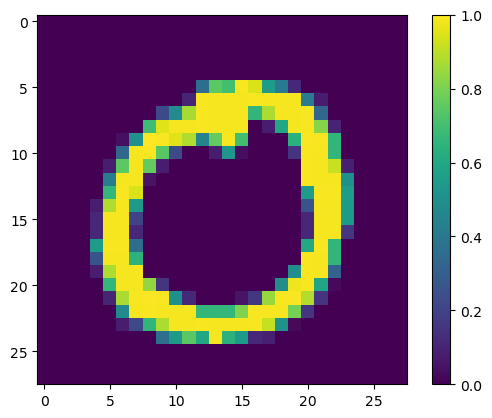

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[50])

plt.imshow(x_train[50, :, :, 0])
plt.colorbar()


In [5]:
x_train_small = tf.image.resize(x_train, (4,2)).numpy()
x_test_small = tf.image.resize(x_test, (4,2)).numpy()

def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          pass

    num_uniq_0 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_1 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 0s: ", num_uniq_0)
    print("Number of unique 1s: ", num_uniq_1)
    print("Number of unique contradicting labels (both 0 and 1): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)
x_test_nocon, y_test_nocon = remove_contradicting(x_test_small, y_test)

Number of unique images: 5970
Number of unique 0s:  5556
Number of unique 1s:  374
Number of unique contradicting labels (both 0 and 1):  40

Initial number of images:  12665
Remaining non-contradicting unique images:  5930
Number of unique images: 1024
Number of unique 0s:  940
Number of unique 1s:  82
Number of unique contradicting labels (both 0 and 1):  2

Initial number of images:  2115
Remaining non-contradicting unique images:  1022


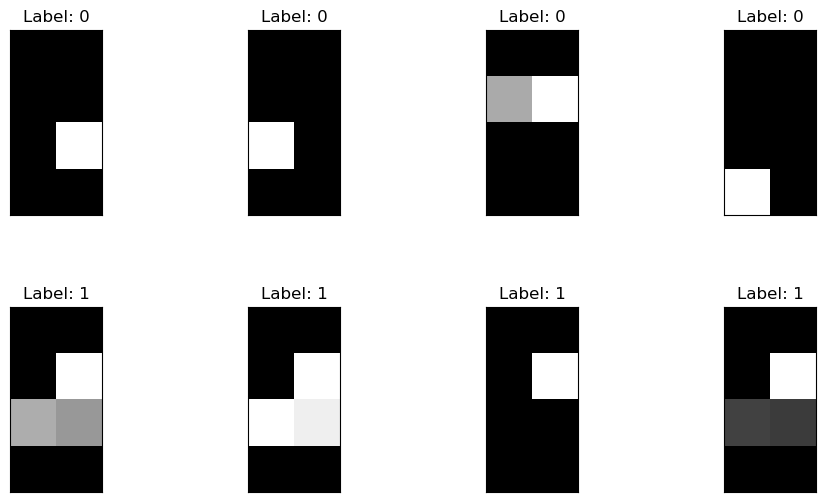

In [6]:
indices_class_0 = [i for i in range(len(y_train_nocon)) if y_train_nocon[i] == 0]
indices_class_1 = [i for i in range(len(y_train_nocon)) if y_train_nocon[i] == 1]

indices_class_0 = indices_class_0[:4]
indices_class_1 = indices_class_1[:4]

fig, ax = plt.subplots(2, 4, figsize=(12, 6), subplot_kw={"xticks": [], "yticks": []})

for i in range(4):
    if i < len(indices_class_0):
        idx = indices_class_0[i]
        ax[0, i].imshow(x_train_nocon[idx].reshape(4, 2), aspect="equal", cmap='gray')
        ax[0, i].set_title("Label: 0")

for i in range(4):
    if i < len(indices_class_1):
        idx = indices_class_1[i]
        ax[1, i].imshow(x_train_nocon[idx].reshape(4, 2), aspect="equal", cmap='gray')
        ax[1, i].set_title("Label: 1")

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

In [7]:
num_samples = 50
def select_samples(x, y, num_samples_per_class=num_samples):
    selected_x = []
    selected_y = []
    classes = np.unique(y)
    
    for cls in classes:
        class_indices = np.where(y == cls)[0]
        if len(class_indices) > 0:
            selected_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
            selected_x.append(x[selected_indices])
            selected_y.append(y[selected_indices])
    
    selected_x = np.concatenate(selected_x)
    selected_y = np.concatenate(selected_y)
    
    return selected_x, selected_y

x_train_final, y_train_final = select_samples(x_train_nocon, y_train_nocon)
x_test_final, y_test_final = select_samples(x_test_nocon, y_test_nocon, int(num_samples*0.4))

print(f"Final training data shape: {x_train_final.shape}")
print(f"Final training labels shape: {y_train_final.shape}")
print(f"Final test data shape: {x_test_final.shape}")
print(f"Final test labels shape: {y_test_final.shape}")

Final training data shape: (100, 4, 2, 1)
Final training labels shape: (100,)
Final test data shape: (40, 4, 2, 1)
Final test labels shape: (40,)


In [8]:
x_train_flattened = x_train_final.reshape(x_train_final.shape[0], -1) 
x_test_flattened = x_test_final.reshape(x_test_final.shape[0], -1)  


y_train_spin = np.where(y_train_final, 1, -1)
y_test_spin = np.where(y_test_final, 1, -1)

In [9]:
train_indices = np.random.permutation(x_train_flattened.shape[0])
x_train_shuffled = x_train_flattened[train_indices]
y_train_shuffled = y_train_spin[train_indices]

test_indices = np.random.permutation(x_test_flattened.shape[0])
x_test_shuffled = x_test_flattened[test_indices]
y_test_shuffled = y_test_spin[test_indices]

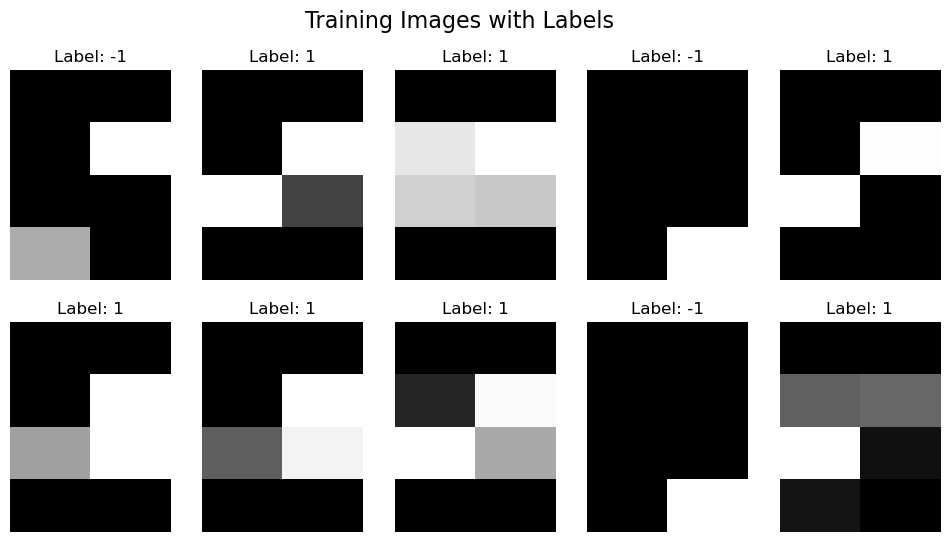

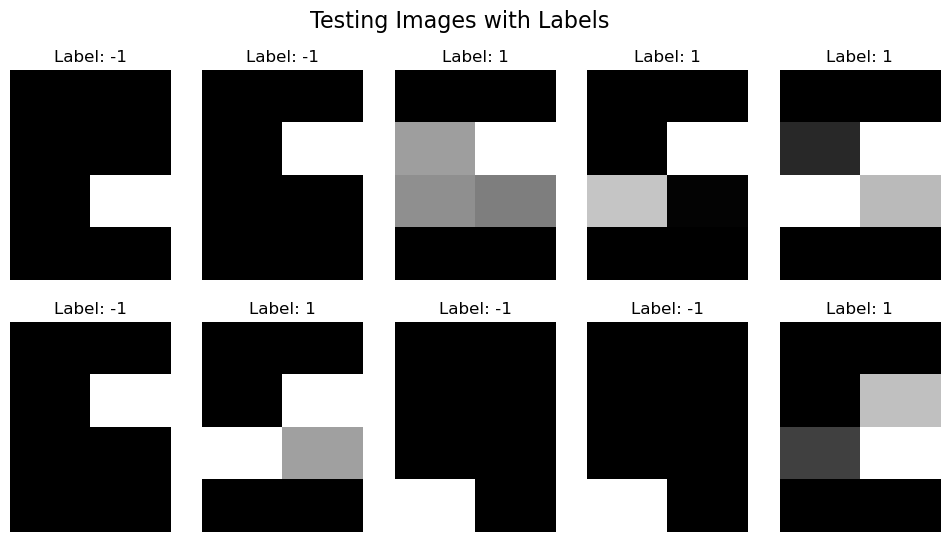

In [14]:
def plot_images_with_labels(images, labels, title, num_images=10):
    fig, axes = plt.subplots(2, num_images // 2, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(images[i].reshape(4, 2), cmap='gray', aspect='auto')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    
    plt.show()

plot_images_with_labels(x_train_shuffled, y_train_shuffled, "Training Images with Labels", num_images=10)

plot_images_with_labels(x_test_shuffled, y_test_shuffled, "Testing Images with Labels", num_images=10)

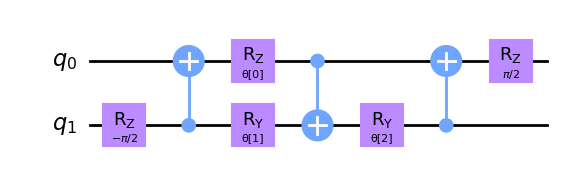

In [15]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

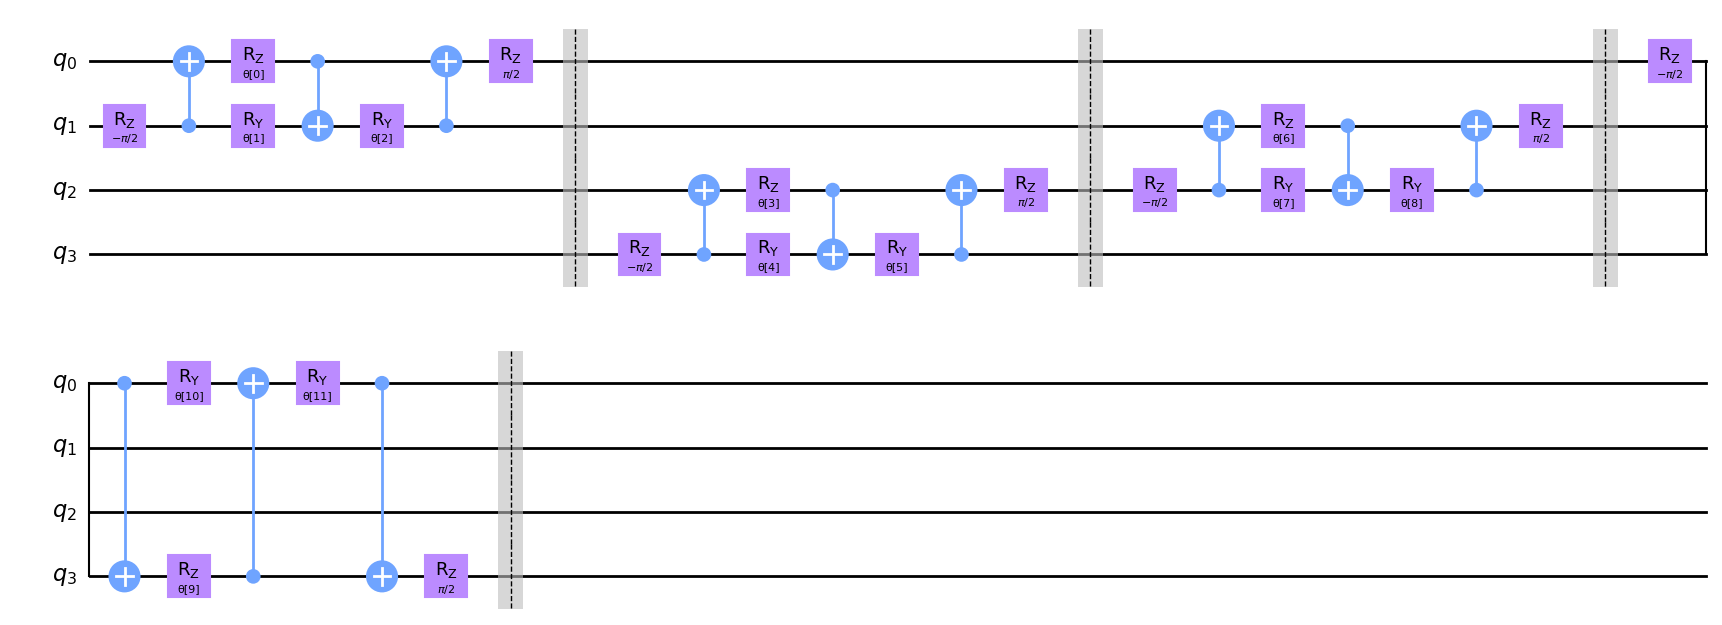

In [16]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


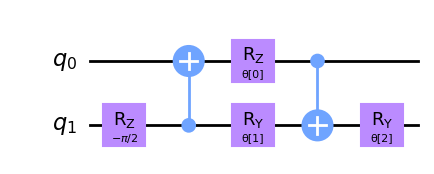

In [17]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

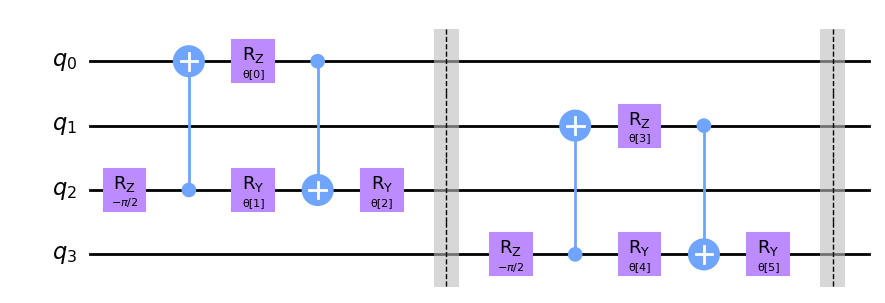

In [18]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [20]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    # estimator=backend,
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

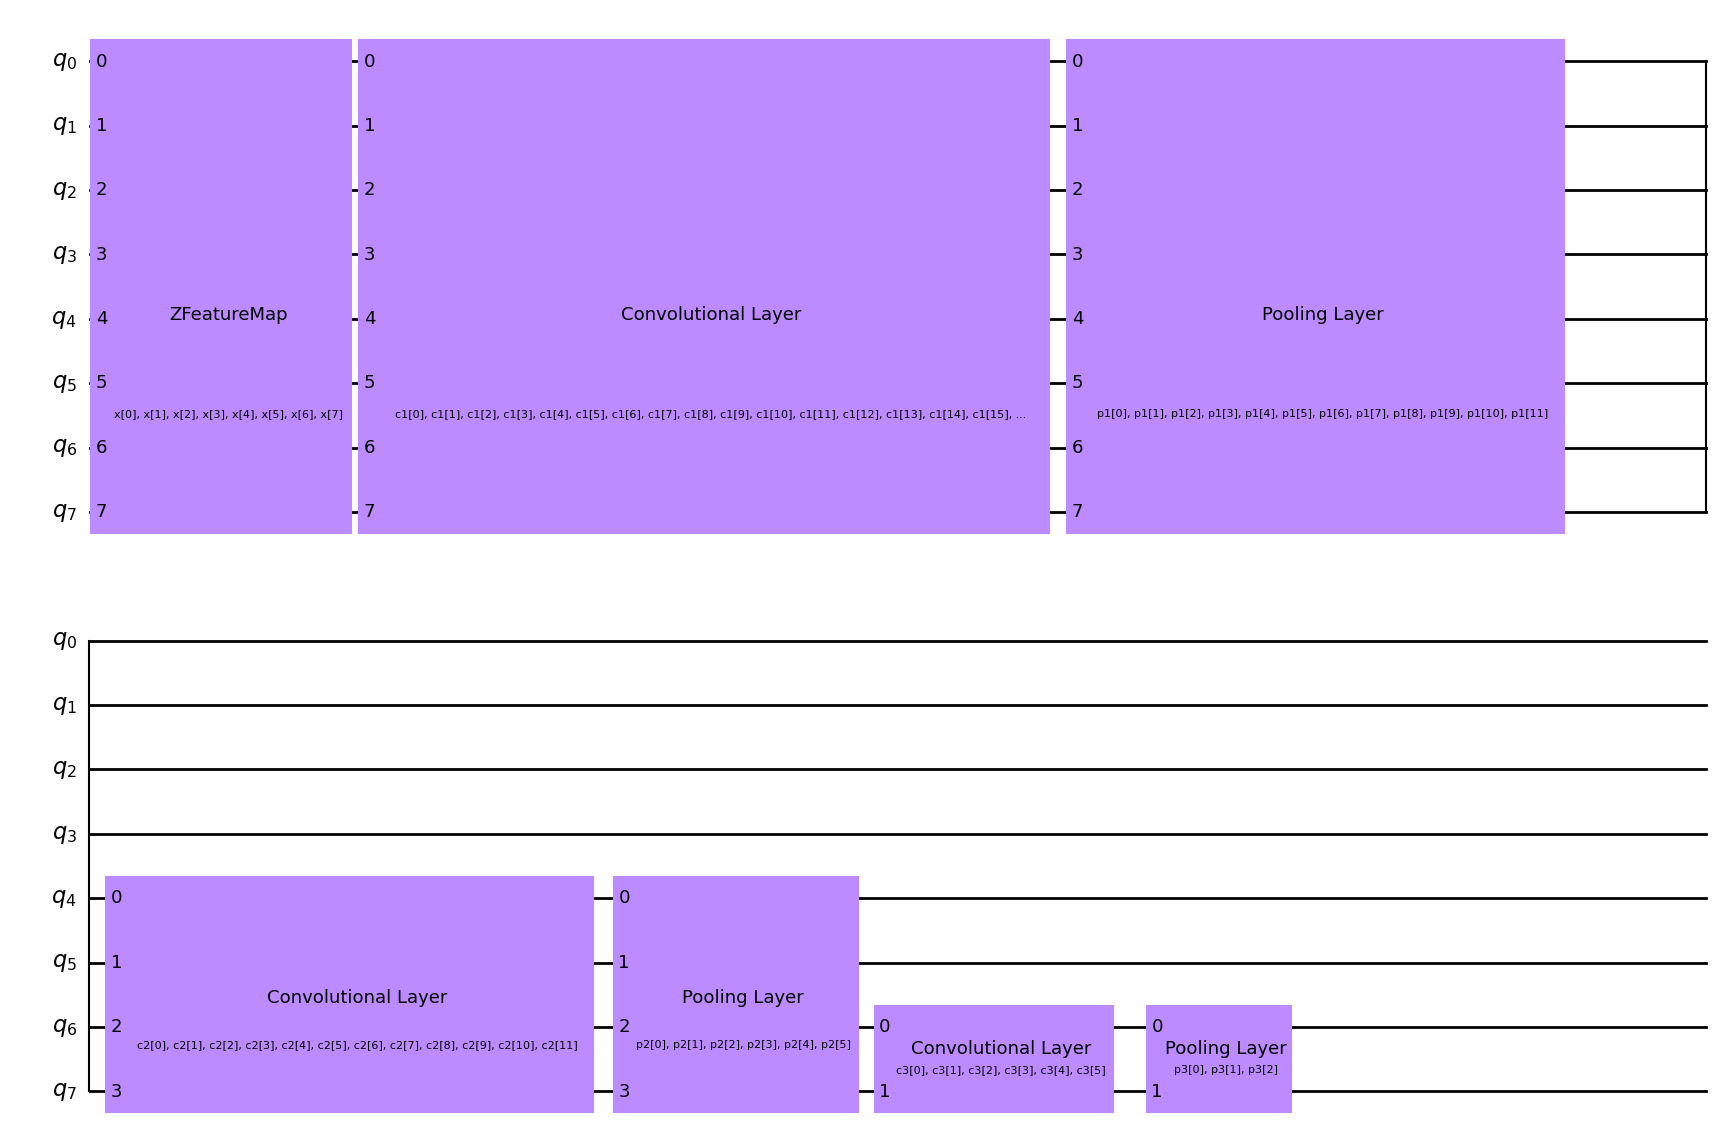

In [21]:
circuit.draw("mpl", style="clifford")

In [22]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

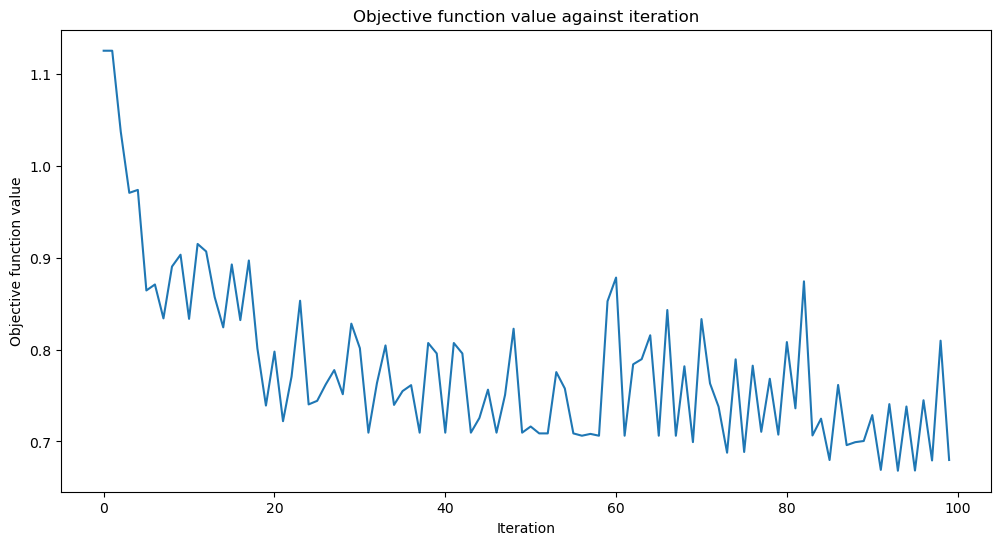

Accuracy from the train data : 88.0%


In [23]:
classifier = NeuralNetworkClassifier(
    qnn,
    # loss='cross_entropy',
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 92.5%


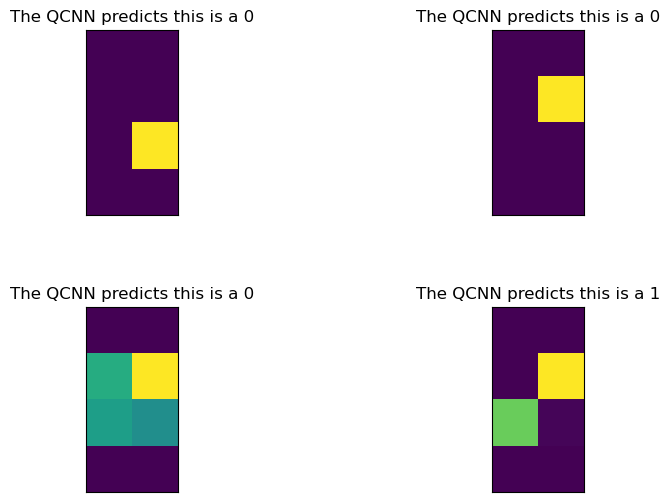

In [24]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

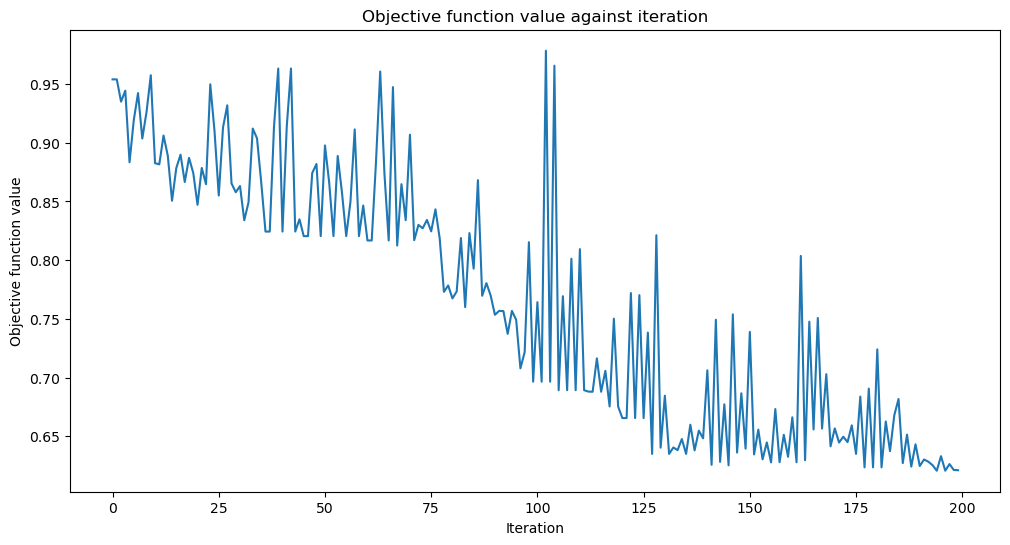

Accuracy from the train data : 76.0%


In [25]:
classifier = NeuralNetworkClassifier(
    qnn,
    # loss='cross_entropy',
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 85.0%


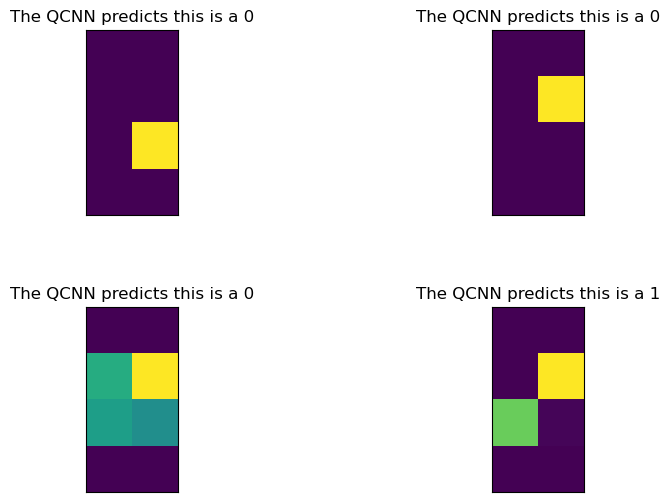

In [26]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

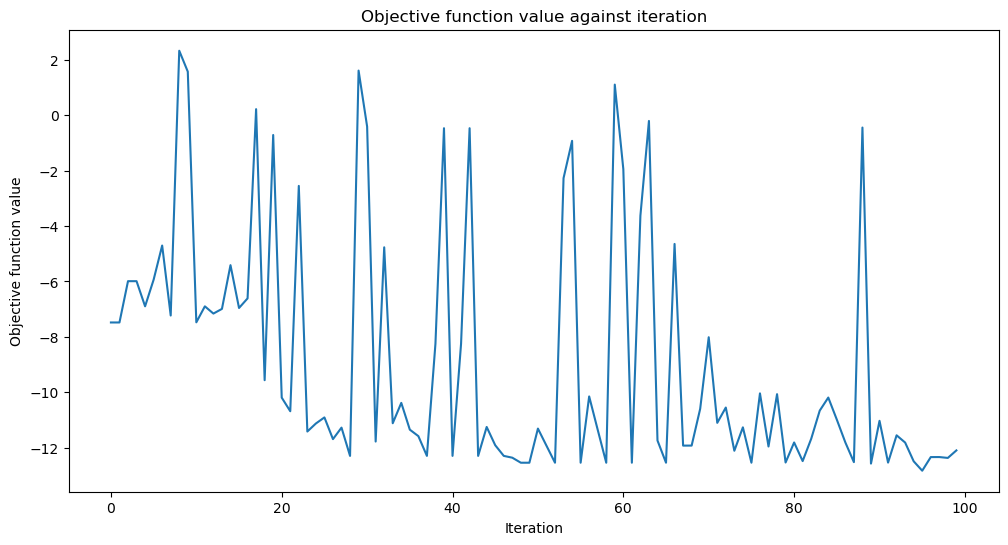

Accuracy from the train data : 92.0%


In [27]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='cross_entropy',
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 87.5%


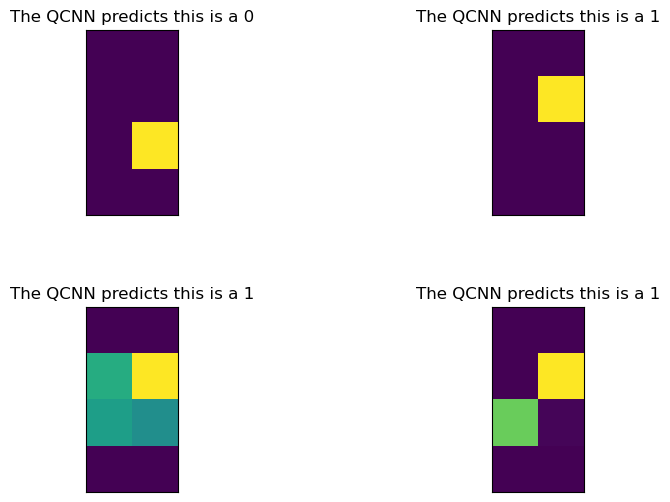

In [28]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

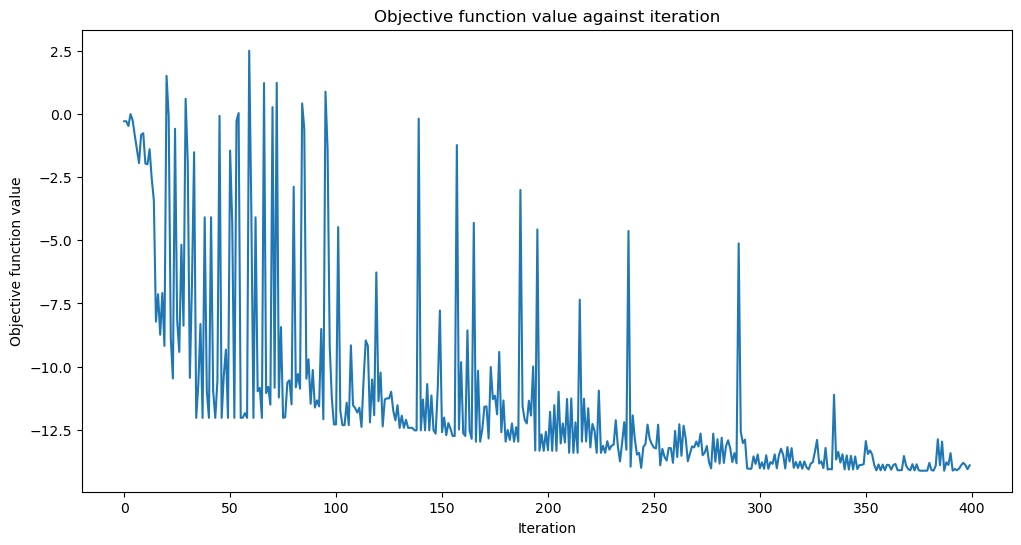

Accuracy from the train data : 98.0%


In [29]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='cross_entropy',
    optimizer=COBYLA(maxiter=400),  # Set max iterations here
    callback=callback_graph,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 92.5%


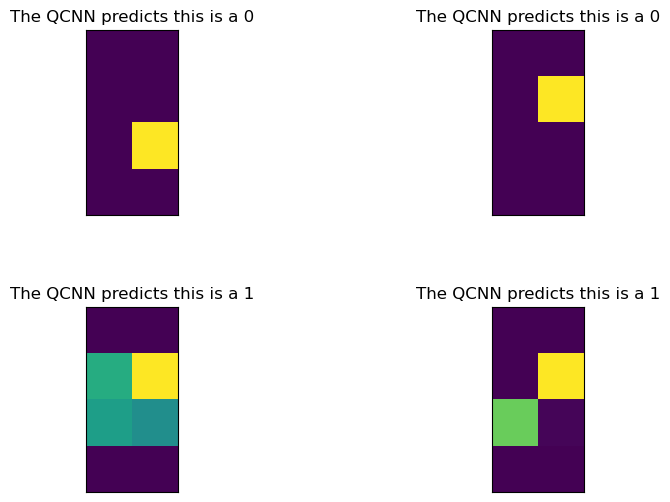

In [30]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

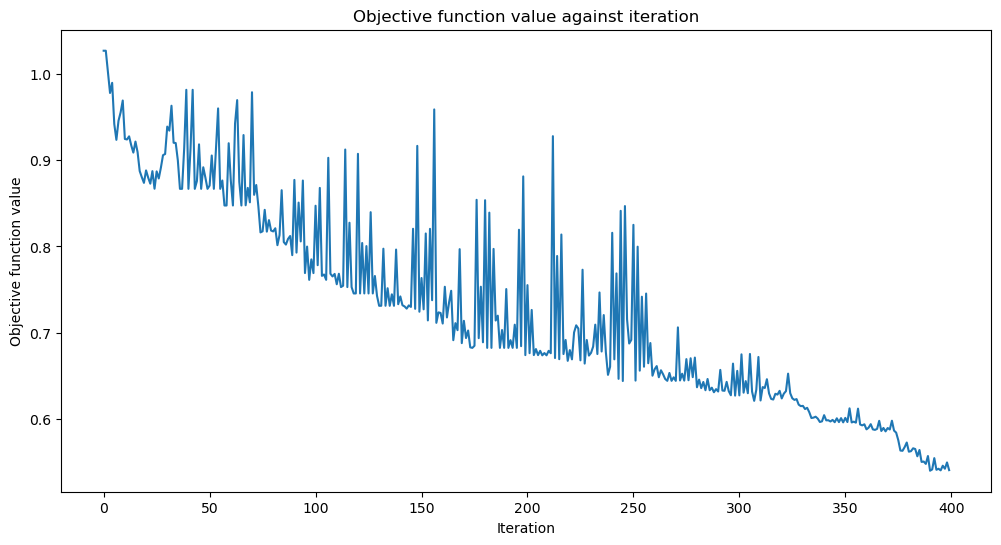

Accuracy from the train data : 76.0%


In [31]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='absolute_error',
    optimizer=COBYLA(maxiter=400),  # Set max iterations here
    callback=callback_graph,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 87.5%


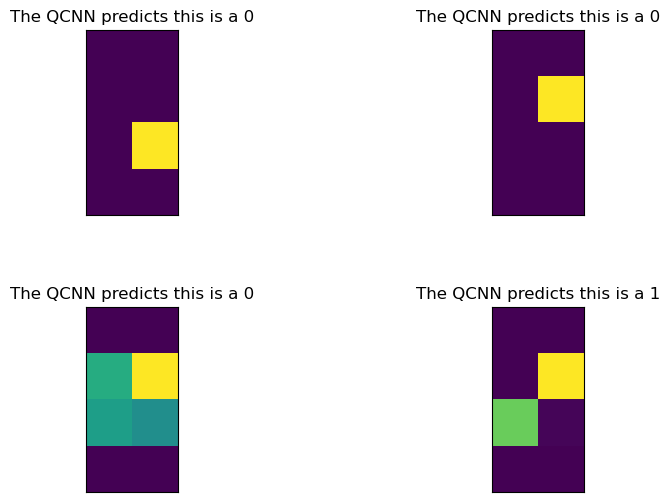

In [32]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

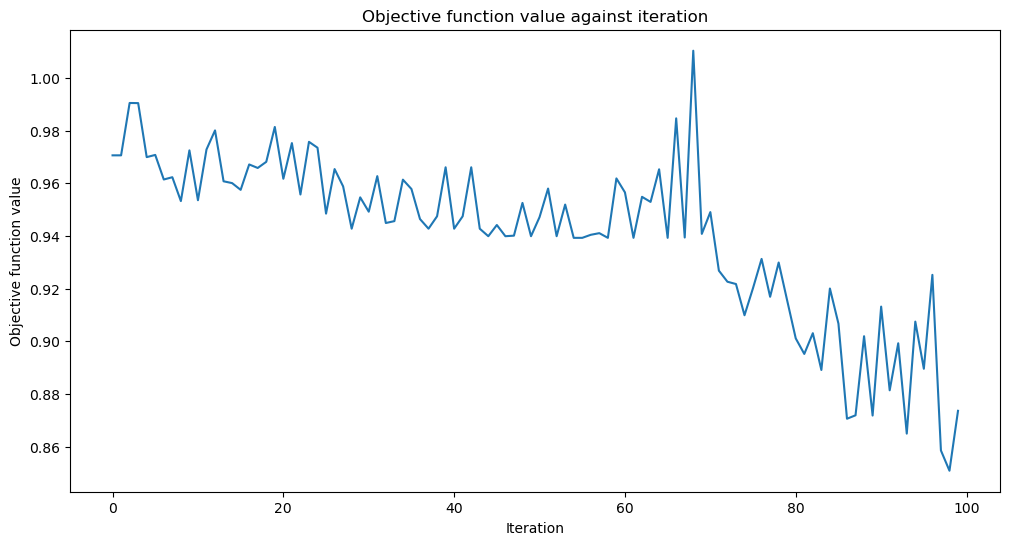

Accuracy from the train data : 62.0%


In [33]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='absolute_error',
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 72.5%


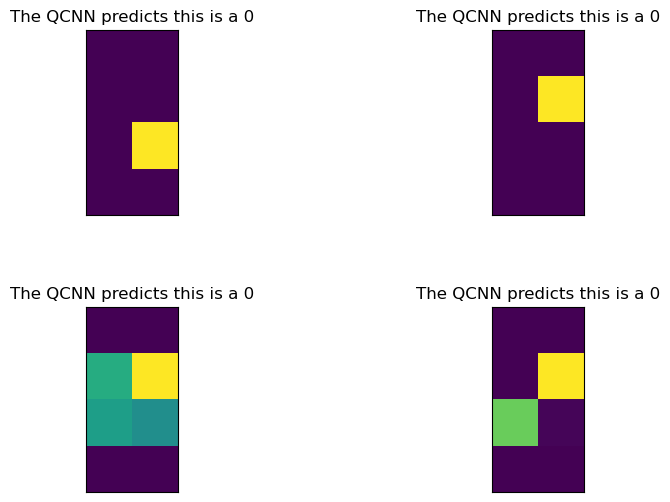

In [34]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

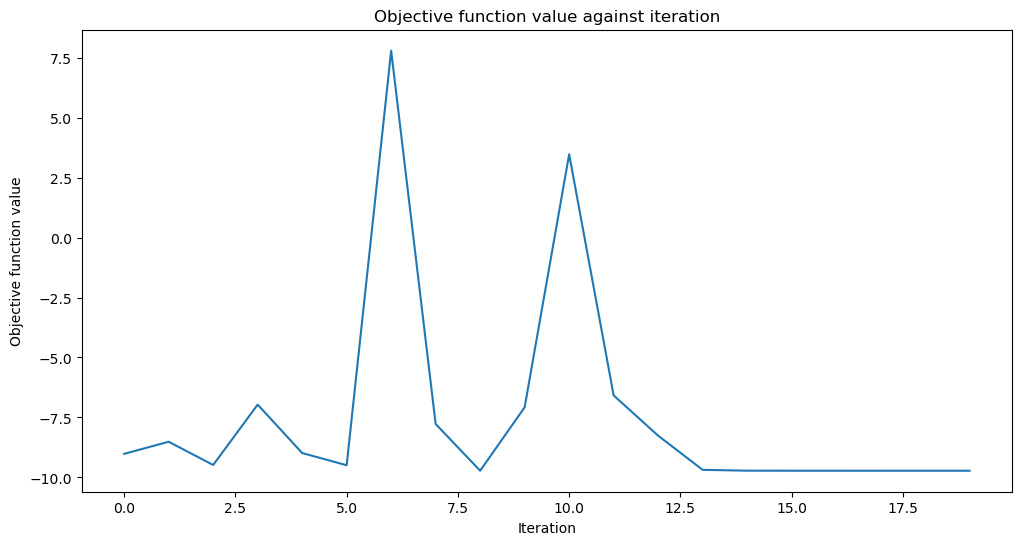

Accuracy from the train data : 84.0%


In [38]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='cross_entropy',
    optimizer=SLSQP(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    # initial_point=initial_point,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 92.5%


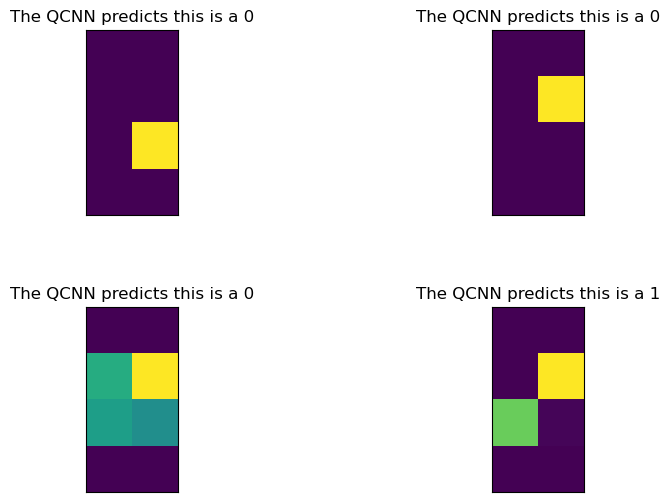

In [39]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [40]:
classifier = NeuralNetworkClassifier(
    qnn,
    loss='cross_entropy',
    optimizer=ADAM(maxiter=100, tol=1e-4, lr=0.01),  # Set max iterations here
    # callback=callback_graph2,
    # initial_point=initial_point,
)

x = np.asarray(x_train_shuffled)
y = np.asarray(y_train_shuffled)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the train data : 75.0%


Accuracy from the test data : 82.5%


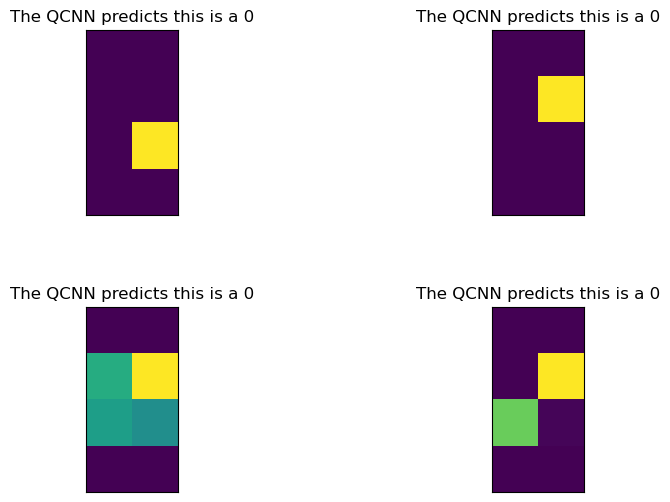

In [41]:
y_predict = classifier.predict(x_test_shuffled)
x = np.asarray(x_test_shuffled)
y = np.asarray(y_test_shuffled)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x_test_shuffled[i].reshape(4, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 0")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a 1")
plt.subplots_adjust(wspace=0.1, hspace=0.5)